Tutorial 7: Adaptive Pixelization
=================================

In this tutorial we will introduce a new `Pixelization` object, called the `VoronoiMagnification` `Pixelization`.

This pixelization does not use a uniform grid of rectangular pixels, but instead uses an irregular grid of `Voronoi`
pixels. So, why would we want to do that? Lets take another quick look at the rectangular grid..

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

We'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

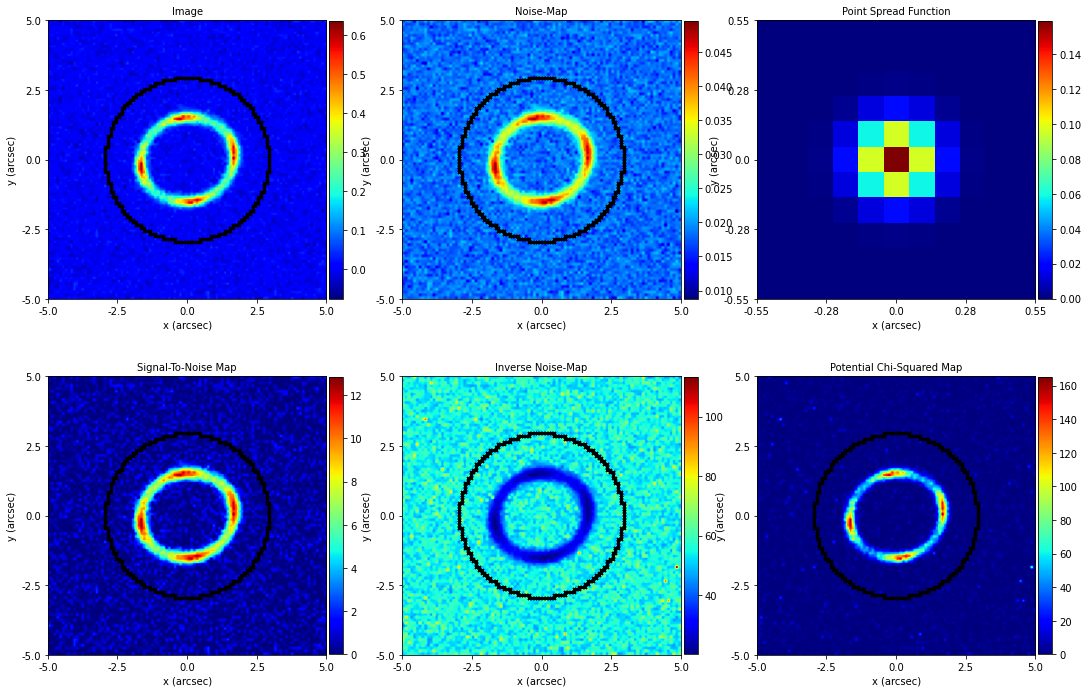

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=3.0,
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

The lines of code below do everything we're used to, that is, setup an image, mask it, trace it via a tracer, 
setup the rectangular mapper, etc.

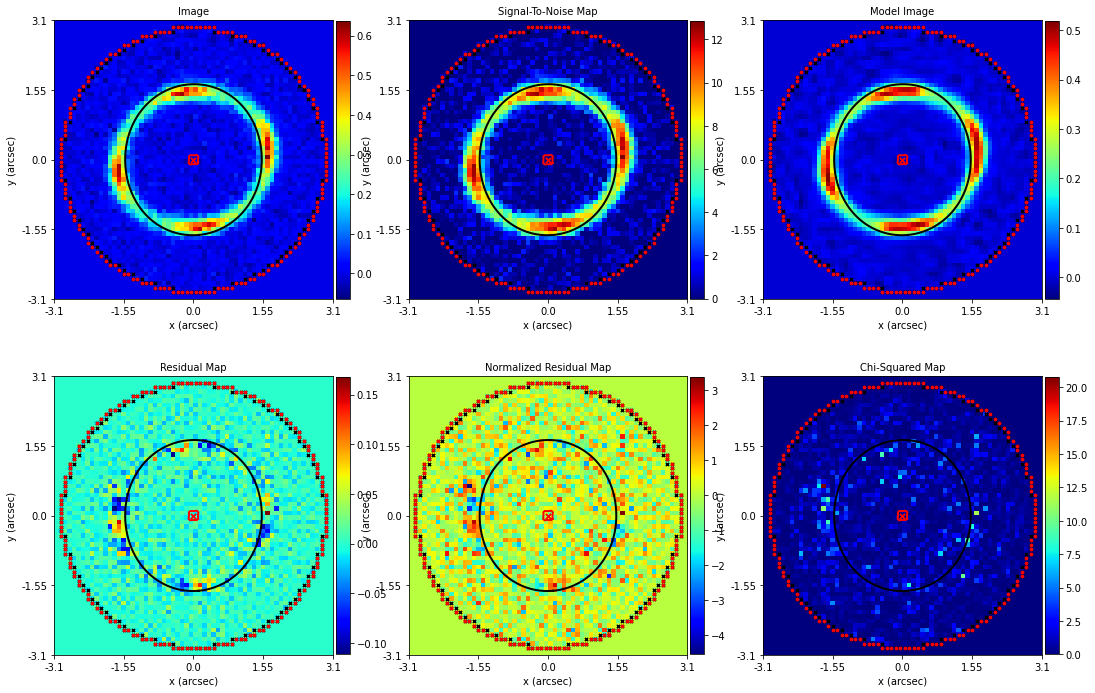

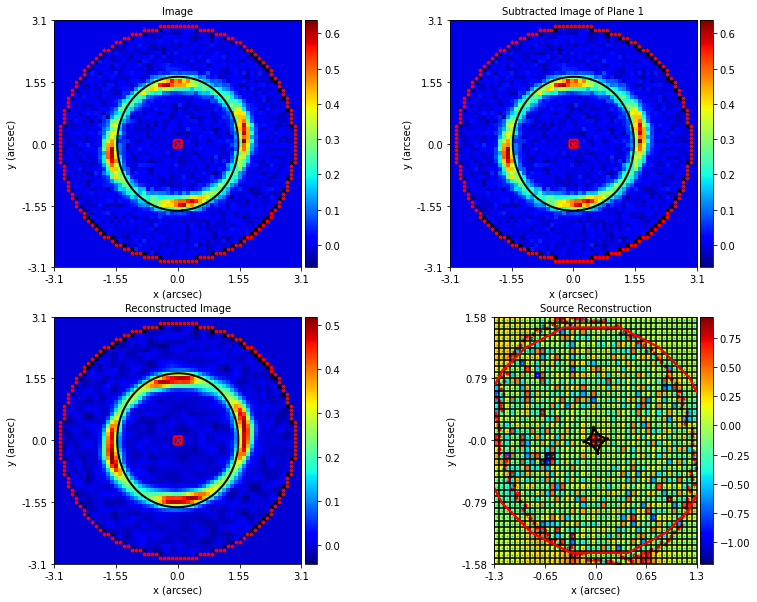

In [3]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

imaging = imaging.apply_mask(mask=mask)

source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=0.5),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

__Advantages and Disadvatanges__

Okay, so lets think about the rectangular pixelization. Is this the optimal way to reconstruct our source? Are there 
features in the source-plane that arn`t ideal? How do you think we could do a better job?

Well, given we are doing a whole tutorial on using a different pixelization, you have probably guessed that the 
rectangular pixelization is not optimal. Infact, its pretty rubbish, and not a pixelization we should actually want to 
model any lenses with!

So what is wrong with the grid? Well, lets think about the source reconstruction.

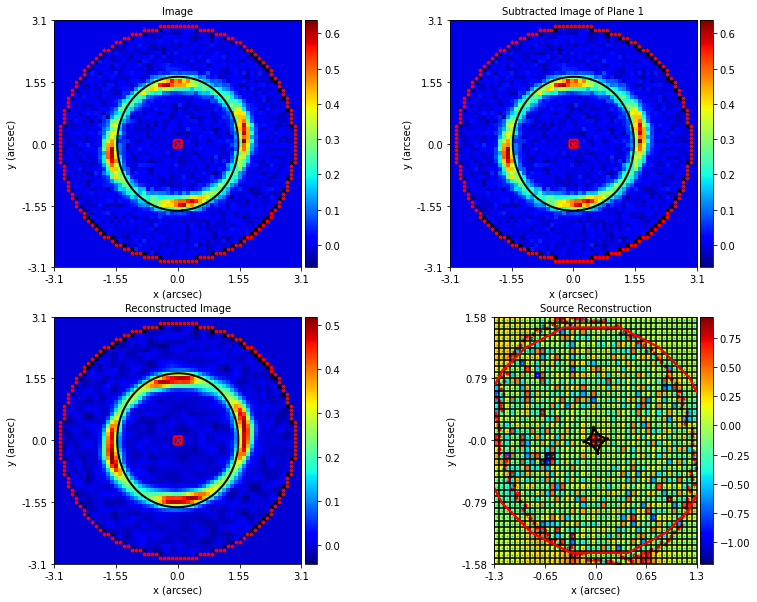

In [4]:
include_2d = aplt.Include2D(mapper_source_pixelization_grid=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_of_planes(plane_index=1)

There is one clear problem, we are using only a small number of the total source pixels to reconstruct the source. The 
majority of source pixels are located away from the source. By my estimate, we are using just 16 pixels (the central 
4x4 grid) out of the 1600 pixels to actually fit the data! The remaining ~1500 pixels are doing *nothing* but fitting 
noise.

This is wasteful and the analysis takes longer to run because of it. However, more importantly, it also means that
regularization is sub-optimal. In tutorial 4, we discussed how the Bayesian evidence of the regularization wants to 
obtain the *simplest* source solution possible. That is, the solution which fits the data using the fewest source 
pixels. Clearly, if we are dedicating a huge number of source pixels to doing *nothing*, our source reconstruction is 
unecessarily complex (and therefore is lower `log_evidence` solution).

If our pixelization could 'focus' its pixels where we actually have more data, e.g. the highly magnified regions of 
the source-plane, we could reconstruct the source using fewer pixels. That`d be great both for computational efficiency 
and increasing the Bayesian log evidence. This is what the Voronoi pixelization does.

__Voronoi Grid__

To achieve this, we first compute an `image-plane sparse grid`, which is a set of sparse coordinates in the image-plane 
that will be ray-traced to the source-plane and define the centres of our source-pixel grid. We compute this grid
directly from a pixelization, by passing it a grid.

In [5]:
adaptive = al.pix.VoronoiMagnification(shape=(20, 20))

image_plane_sparse_grid = adaptive.sparse_grid_from_grid(grid=imaging.grid)

We can plot this grid over the image, to see that it is a coarse grid of $(y,x)$ coordinates that over-lay the image 
itself.

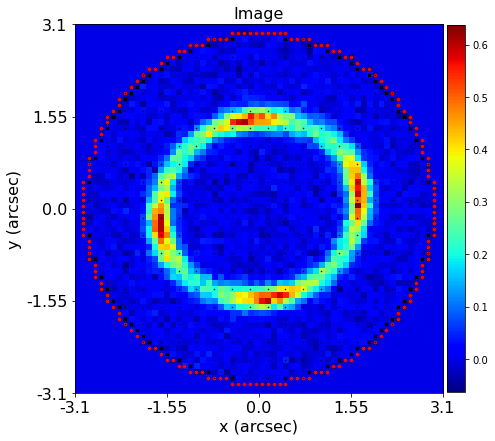

In [6]:
visuals_2d = aplt.Visuals2D(grid=image_plane_sparse_grid, mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures_2d(image=True)

When we pass a `Tracer` a source galaxy with this `Pixelization` object it automatically computes the ray-traced 
source-plane Voronoi pixelization using the grid above. Thus, our Voronoi pixelization is used by the tracer`s fit.

In [7]:
source_galaxy = al.Galaxy(
    redshift=1.0, pixelization=adaptive, regularization=al.reg.Constant(coefficient=1.0)
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

If we look at the lens fit, we'll see that our source-plane no longer uses rectangular pixels, but Voronoi pixels!

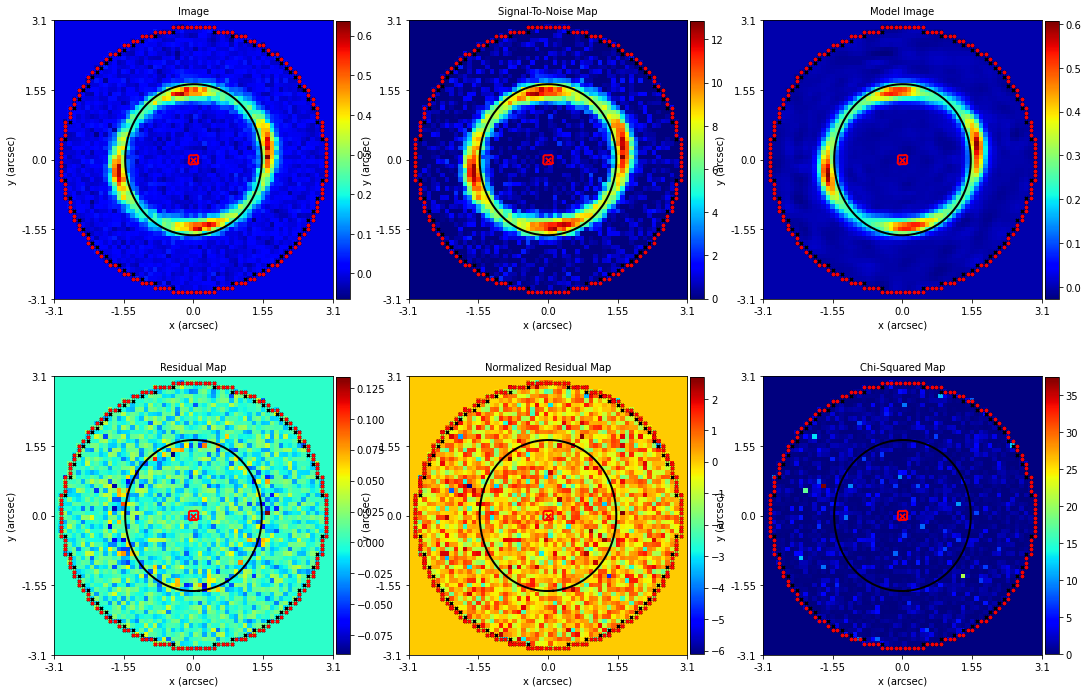

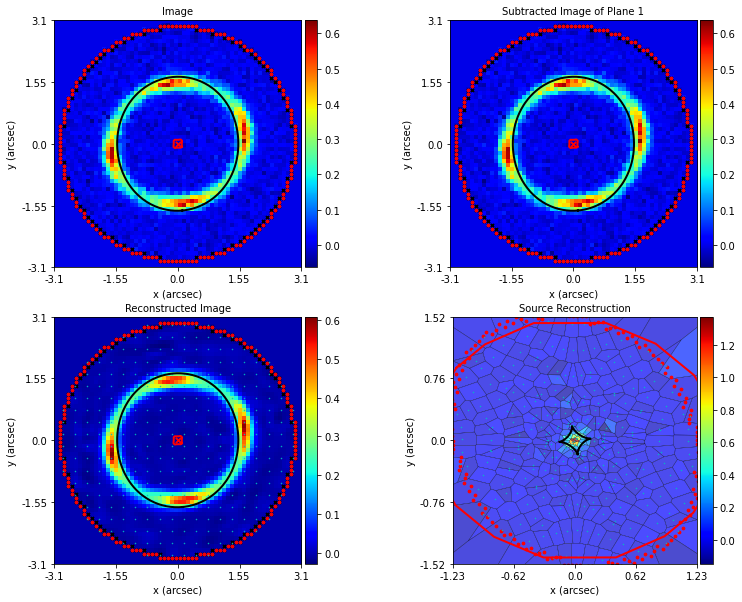

In [8]:
fit = al.FitImaging(imaging=imaging, tracer=tracer)

include_2d = aplt.Include2D(
    mask=True, mapper_data_pixelization_grid=True, mapper_source_pixelization_grid=True
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

And we can take a closer inspection of the inversion itself.

Clearly, this is an improvement. we are using fewer pixels than the rectangular grid (400, instead of 1600) and
reconstructing the source is far greater detail. A win all around!

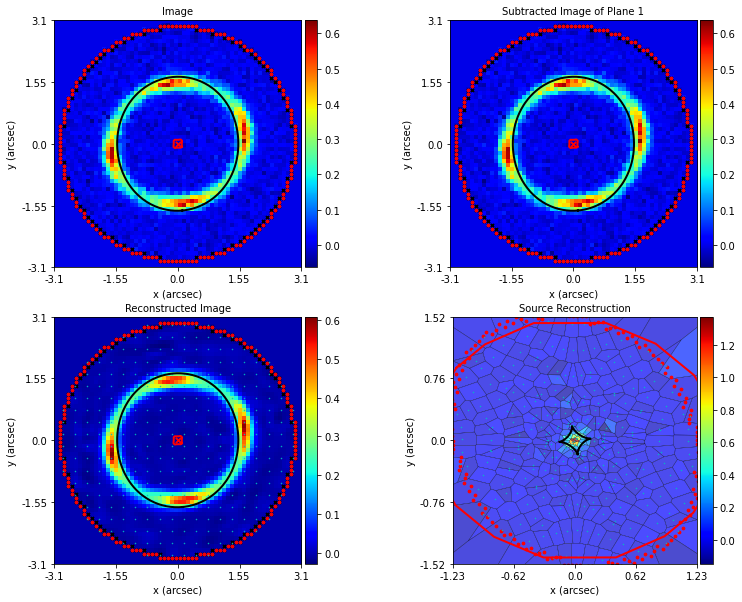

In [9]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_of_planes(plane_index=1)

__Wrap Up__

On our rectangular grid, we regularized each source pixel with its 4 neighbors. We compared their fluxes, summed 
the differences, and penalized solutions where the differences were large. For a Voronoi grid, we do the same thing, 
now comparing each source-pixel with all other source-pixels with which it shares a direct vertex. This means that 
different source-pixels may be regularized with different numbers of source-pixels, depending on how many neighbors 
are formed.

However, the `VoronoiMagnification` pixelization is still far from optimal. There are lots of source-pixels 
effectively fitting just noise. We may achieve even better solutions if the central regions of the source were 
reconstructed using more pixels, whilst even less source pixels are dedicated to the outskirts of the source plane. 

So, how do we improve on this? Well, you'll have to wait until chapter 5, when we introduce **PyAutoLens**`s adaptive 
functionality, called 'hyper-mode'.

In the mean time, you may wish to experiment with using both Rectangular and VoronoiMagnification grids to fit 
lenses which can be easily achieve by changing the input pixelization given to a pipeline.